# Load and setup the data and variables

In [1]:
expr_mouse = "../../data/prepared/mouse_scaled.tsv.gz"
expr_human = "../../data/prepared/human_scaled.tsv.gz"
conservation = "../../data/prepared/aucs.tsv.gz"

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import decomposition
import statsmodels.formula.api as smf

In [3]:
aurocs = pd.read_csv(conservation, sep="\t", index_col=0).mean(axis=1)
aurocs.rename('auroc', inplace=True)

NME3        0.655923
PPP1R9A     0.702206
TRAK2       0.718198
NGF         0.912152
TVP23A      0.812818
              ...   
MON1B       0.671044
POLR1D      0.544324
PAMR1       0.397167
CDKN1C      0.720222
ARHGAP24    0.694791
Name: auroc, Length: 11139, dtype: float64

In [4]:
mouse = pd.read_csv(expr_mouse, sep="\t", header=0, index_col=[0,1])
human = pd.read_csv(expr_human, sep="\t", header=0, index_col=[0,1])
mouse.head().iloc[:,:5]

Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

In [5]:
mouse.shape

(280, 19074)

In [6]:
human.shape

(111, 12383)

We have to capitalize all of the mouse gene names.

In [7]:
mouse.columns = [gene.upper() for gene in mouse.columns]
human.columns = [gene.upper() for gene in human.columns]
mouse.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE', 'AC132444.5',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=19074)

We're only interested in genes that are shared between the two species.

In [8]:
genes = list(set(mouse.columns).intersection(human.columns))
len(genes)

11139

In [9]:
mouse_genes = mouse.loc[:,genes]
human_genes = human.loc[:,genes]
human_genes.shape

(111, 11139)

# Obtain the mean expression over samples in each celltype

In [10]:
mean_mouse = mouse_genes.groupby('celltype').mean().T
mean_mouse.index.names = ['gene']
mean_human = human_genes.groupby('celltype').mean().T
mean_human.index.names = ['gene']
mean_mouse.head().iloc[:,:5]

celltype,E_1,E_10,E_11,E_12,E_14
gene,,,,,
ABCC5,114.105614,113.847439,116.707363,115.633966,115.622787
UTP6,62.456520,57.083521,57.877447,59.387534,56.178219
MRPS36,83.995156,72.954217,84.734344,73.513196,78.750876
RFX8,4.921504,4.433764,2.570924,4.280603,5.232879
ITGA6,67.963799,44.860394,34.004155,25.315018,49.571480


In [11]:
mean_mouse.shape

(11139, 33)

In [12]:
mean_human.shape

(11139, 58)

Let's also merge the data into a single dataframe.

In [13]:
full_mouse = mean_mouse.merge(aurocs, left_index=True, right_index=True)
full_human = mean_human.merge(aurocs, left_index=True, right_index=True)
full_mouse.head().iloc[:,-5:]

,N_4,N_5,N_6,N_7,auroc
ABCC5,108.506078,109.419061,85.199071,94.034106,0.650383
UTP6,77.184174,70.937921,70.563884,76.975867,0.379132
MRPS36,77.986916,73.242929,84.712468,90.336224,0.877538
RFX8,4.334602,14.386777,2.573905,13.060381,0.516316
ITGA6,123.575118,19.846531,137.529357,96.817956,0.484611


# Perform a basic regression without correcting for anything

In [14]:
mouse_sumstats = {}
for celltype in mean_mouse.columns:
    model = smf.ols(formula=f"{celltype} ~ auroc", data=full_mouse)
    res = model.fit()
    mouse_sumstats[celltype] = res.summary2().tables[1].loc['auroc']

In [15]:
mouse_res = pd.DataFrame(mouse_sumstats).T
mouse_res.index.names = ['celltype']
mouse_res.head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
celltype,,,,,,
E_1,82.701405,2.176751,37.993045,4.120439e-297,78.434587,86.968223
E_10,78.584727,2.148315,36.579703,9.452054e-277,74.373650,82.795805
E_11,85.629296,2.273769,37.659622,2.965637e-292,81.172306,90.086287
E_12,77.048290,2.227557,34.588695,4.200538e-249,72.681884,81.414696
E_14,78.263538,2.152101,36.366108,1.000300e-273,74.045039,82.482037


In [16]:
human_sumstats = {}
for celltype in mean_human.columns:
    model = smf.ols(formula=f"{celltype} ~ auroc", data=full_human)
    res = model.fit()
    human_sumstats[celltype] = res.summary2().tables[1].loc['auroc']

In [17]:
human_res = pd.DataFrame(human_sumstats).T
human_res.index.names = ['celltype']
human_res.head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
celltype,,,,,,
E_1,75.276685,2.941070,25.595004,1.897390e-140,69.511668,81.041702
E_10,79.631160,2.796042,28.479957,2.822966e-172,74.150422,85.111897
E_11,76.549908,2.881447,26.566485,7.813207e-151,70.901762,82.198053
E_12,82.781629,2.982992,27.751211,5.884191e-164,76.934437,88.628821
E_13,75.030732,2.854417,26.285831,8.473850e-148,69.435569,80.625895


# Plot the distribution of the expression correlation matrix

In [84]:
def offdiag(corr):
    offdiag_idxs = np.where(~np.eye(corr.shape[0],dtype=bool))
    return corr[offdiag_idxs]

In [93]:
def sample_corr(expr):
    corr = np.corrcoef(expr.values, expr.values)[:expr.shape[0], :expr.shape[0]]
    return corr

In [116]:
def plot_corr(expr):
    corr_offdiag = offdiag(sample_corr(expr))
    _, bins, ax = plt.hist(corr_offdiag, bins=1000, density=True)
    plt.plot(bins, norm.pdf(bins, 0, 1/np.sqrt(expr.shape[1]-2)))

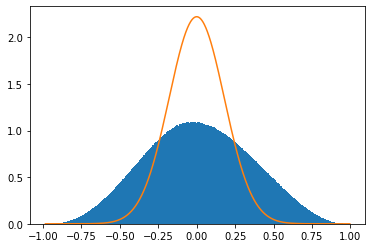

In [117]:
plot_corr(mean_mouse)

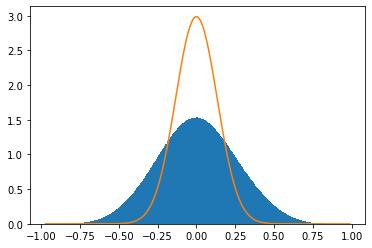

In [118]:
plot_corr(mean_human)

# Correct for gene correlation by regressing out PCs

Let's first obtain the PCs of each expression matrix.

In [67]:
def get_PCs(expr):
    pca = decomposition.PCA(svd_solver='full')
    pca.fit(expr.values)
    exp_var = pca.explained_variance_
    plt.scatter(range(len(exp_var)), exp_var)
    return pca

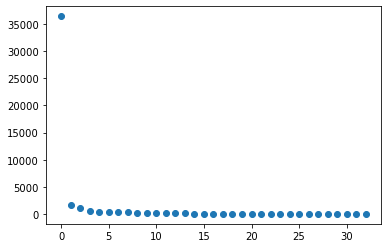

In [68]:
mouse_pca = get_PCs(mean_mouse)

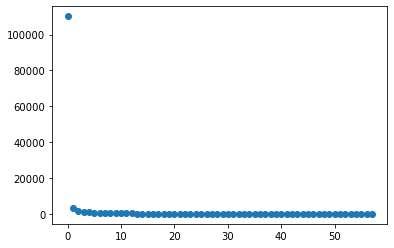

In [69]:
human_pca = get_PCs(mean_human)

Seems like the first PC captures most of the variance.

In [151]:
def regress_PC1(pca, expr):
    transformed = pca.transform(expr.values)
    transformed[:,3:] = 0
    pc1_vals = pca.inverse_transform(transformed)
    return expr - pc1_vals

In [152]:
mouse_resid = regress_PC1(mouse_pca, mean_mouse)
mouse_resid.head().iloc[:,:5]

celltype,E_1,E_10,E_11,E_12,E_14
gene,,,,,
ABCC5,-0.911895,0.004210,-0.259742,0.743521,1.422295
UTP6,3.578106,-0.668863,-1.780902,1.258263,-1.523440
MRPS36,5.017179,-5.096337,4.492523,-5.141458,0.660220
RFX8,0.546203,-1.177907,-0.409885,-0.017514,0.066264
ITGA6,19.147682,-0.894274,-15.115413,-20.977589,3.552524


In [153]:
human_resid = regress_PC1(human_pca, mean_human)
human_resid.head().iloc[:,:5]

celltype,E_1,E_10,E_11,E_12,E_13
gene,,,,,
ABCC5,-1.256938,-1.693086,3.841971,-0.042953,1.343075
UTP6,2.268369,1.739409,3.729466,5.361736,-0.662301
MRPS36,0.070770,0.194381,-1.900634,-7.892036,1.417355
RFX8,-18.550059,13.862629,-38.323870,-13.723820,16.404073
ITGA6,27.246984,10.548709,-13.831402,-27.007644,-47.207557


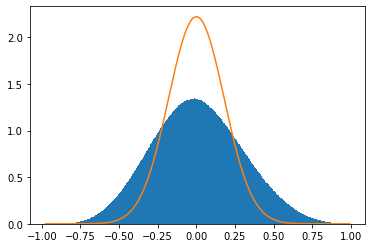

In [154]:
plot_corr(mouse_resid)

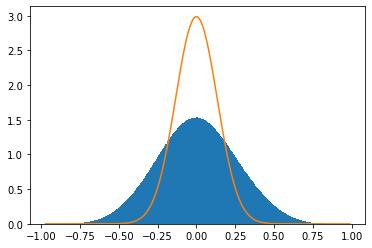

In [157]:
plot_corr(mean_human)

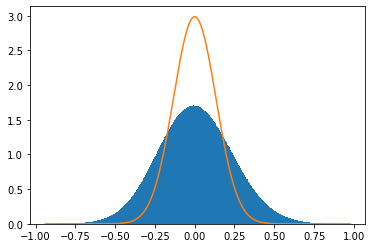

In [158]:
plot_corr(human_resid)

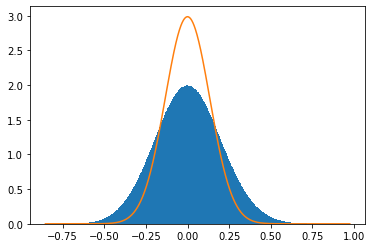

In [161]:
plot_corr((human_resid - human_resid.mean())/human_resid.std())